First off install dependencies. This assumes that the notebook is run in the correct virtualenv.

In [ ]:
!pip install pandas numpy seaborn gpy sklearn plotly

## Rename & Repackage Data
The data was in a format I did not prefer so it is renamed and repackaged here.

In [54]:
import pandas as pd

def repackage(from_path, to_path):
    data = pd.read_pickle(from_path)
    data.timestamp = data.timestamp.apply(pd.to_datetime)
    data = data.rename(columns = {
        'latitude': 'lat',
        'longitude': 'lon',
        'journey_number': 'traj',
        'segment_number': 'seg', 
        'speed': 'speed',
        'event': 'event',
        'timestamp': 'timestamp'
    })
    data.to_pickle(to_path)
    
repackage('../data/203_train.p', '../data/train3.pkl')
repackage('../data/203_test.p', '../data/test3.pkl')

In [80]:
#data = pd.read_pickle('../data/train3.pkl')
#data.head()
def mean_timestamp(timestamps):    
    return pd.to_datetime(timestamps.values.astype(np.int64).mean())

X = data.iloc[0].copy()
data.iloc[4].timestamp = 6 #
print(X.timestamp)
X.timestamp = mean_timestamp(data.iloc[:10].timestamp)
print(X.timestamp)
compressed_data = data.drop(['timestamp', 'event', 'seg', 'station', 'line', 'traj'], axis=1).apply(np.mean, axis=0)
compressed_data['timestamp'] = mean_timestamp(data.iloc[:10].timestamp)# pd.Timestamp(2017, 1, 1, 12)
#compressed_data.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data

2018-02-16 03:48:43.080000
2018-02-16 03:48:43.108000


Unnamed: 0                485.027
vehicle_id                5451.22
lon                       58.4093
lat                       15.5723
direction                  123.11
speed                      5.1206
timestamp     1518752923108000000
dtype: object

## Learn  a model

Optimization restart 1/1, f = -113.72167396895885
Optimization restart 1/1, f = -560.2268566226223
Optimization restart 1/1, f = -37.67507098470588


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Documents\plugg\msc\model\model.py:91: DataConversionWarning:Data with input dtype int64 were all converted to float64 by StandardScaler.
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


GP_regression.,value,constraints,priors
rbf.variance,7.273930826702832,+ve,
rbf.lengthscale,2.90149911130509,+ve,
Gaussian_noise.variance,0.02,+ve fixed,


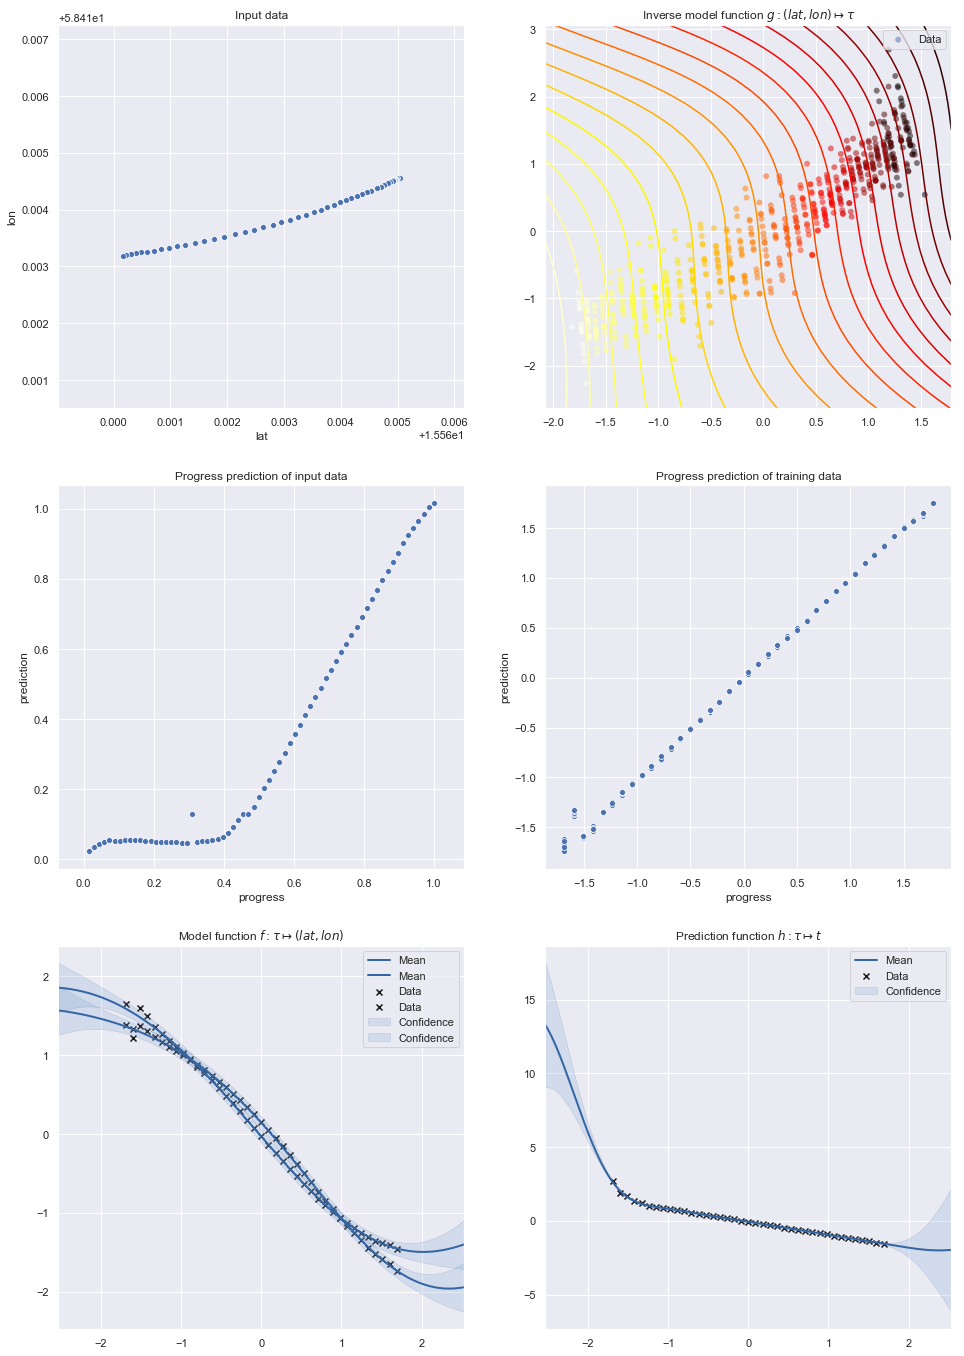

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display import display, clear_output
from model import learn_trajectory_model, plot_function, gamma_prior, FunctionModelPriors, predict

%matplotlib inline
sns.set(style="darkgrid")

trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
n_trajs_to_use = 5 # len(n_trajs)

np.random.seed(12345)
trajs_to_use = frozenset(np.random.choice(n_trajs, size=n_trajs_to_use, replace=False))
trajs = data[data.traj.transform(lambda j: j in trajs_to_use)]
traj_ixs = trajs.traj.unique()


f_priors = FunctionModelPriors(None, None, None)
g_kern_ls_prior = None #gamma_prior(0.5, .002)
g_kern_var_prior = None # gamma_prior(1, .5)
g_kern_lik_prior = None
g_priors = FunctionModelPriors(
    g_kern_ls_prior, 
    g_kern_var_prior, 
    g_kern_lik_prior)
h_priors = FunctionModelPriors(None, None, None)

route_n = 3
seg_n = 2
n_restarts = 1
fix_f_likelihood = 0.02
n_augment_samples = 15
augment_sigma = 1.1
stop_compress_delta=5e-3
seg_one = trajs[(trajs.traj == traj_ixs[0]) & (trajs.seg == seg_n)]
codomain_f = ['lat', 'lon']
domain_h = ['lat', 'lon']
m = learn_trajectory_model(
    seg_one, 
    route_n,
    seg_n,
    codomain_f, 
    domain_h,
    f_priors=f_priors,
    g_priors=g_priors,
    h_priors=h_priors,
    n_restarts=n_restarts,    
    stop_compress_delta=stop_compress_delta,
    fix_f_likelihood=fix_f_likelihood,
    n_augment_samples=n_augment_samples,
    augment_sigma=augment_sigma)

n_rows = 3
n_cols = 2
fig_size = 8
_fig, axs = plt.subplots(
    nrows=n_rows, 
    ncols=n_cols, 
    figsize=(fig_size*n_cols, 
             fig_size*n_rows))

# Input data
sns.scatterplot(data=seg_one, x='lat', y='lon', ax=axs[0][0])
axs[0][0].set_title('Input data')
axs[0, 0].set_aspect('equal', 'datalim')

# h for input data
mean, _  = predict(m.g, seg_one[['lat', 'lon']].values)
N = seg_one.shape[0]
progress = [(x + 1) / N for x in range(N)]
df = pd.DataFrame({'prediction': mean.T[0], 'progress': progress})
sns.scatterplot(data=df, x='progress', y='prediction', ax=axs[1][0])
axs[1][0].set_title('Progress prediction of input data')
axs[1, 0].set_aspect('equal', 'datalim')

# Training data
plot_function(m.g, ax=axs[0][1])
axs[0][1].set_title(r'Inverse model function $g: (lat,lon) \mapsto \tau$')

# H for training data
mean, _  = m.g.model.predict(m.g.model.X)
df = pd.DataFrame({'prediction': mean.T[0], 'progress': m.g.model.Y.flatten()})
sns.scatterplot(data=df, x='progress', y='prediction', ax=axs[1][1])
axs[1][1].set_title('Progress prediction of training data')

# f
plot_function(m.f, ax=axs[2][0])
axs[2][0].set_title(r'Model function $f: \tau \mapsto (lat, lon)$')

# h
plot_function(m.h, ax=axs[2][1])
axs[2][1].set_title(r'Prediction function $h: \tau \mapsto t$')

m.g.model

In [2]:
from model import acquire_db_conn, save_model

conn = acquire_db_conn()

res = save_model(m, conn)
res

19 20 21


2

In [1]:
from model import acquire_db_conn, load_models
conn = acquire_db_conn()
with conn:
    models = load_models(2, 3, conn)
    
    

['f', {'name': 'GP regression', 'class': 'GPy.models.GPRegression', 'X': [[-1.688194301613413], [-1.5993419699495492], [-1.5104896382856854], [-1.4216373066218218], [-1.3327849749579577], [-1.2439326432940938], [-1.15508031163023], [-1.066227979966366], [-0.9773756483025022], [-0.8885233166386385], [-0.7996709849747745], [-0.7108186533109107], [-0.6219663216470469], [-0.5331139899831829], [-0.4442616583193191], [-0.3554093266554553], [-0.2665569949915914], [-0.17770466332772747], [-0.08885233166386373], [0.0], [0.08885233166386393], [0.17770466332772786], [0.2665569949915918], [0.3554093266554557], [0.44426165831931963], [0.5331139899831832], [0.6219663216470471], [0.710818653310911], [0.799670984974775], [0.8885233166386388], [0.9773756483025025], [1.0662279799663663], [1.1550803116302302], [1.2439326432940943], [1.3327849749579581], [1.421637306621822], [1.5104896382856856], [1.5993419699495495], [1.6881943016134133]], 'Y': [[1.384643425122412, 1.64641151000126], [1.2161098844671623,

In [3]:
from model import plot_function
plot_function(models.f)

AttributeError: 'NoneType' object has no attribute 'set_xlim'

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Unnamed: 0,timestamp,event,vehicle_id,line,lon,lat,direction,speed,station,traj,seg,type
0,206.333333,2018-02-16 11:23:20.333333248,ObservedPositionEvent,5415.0,0,58.414563,15.565022,241.699997,2.82,NaN,36,2,compressed
1,216.500000,2018-02-16 11:23:29.722222336,ObservedPositionEvent,5415.0,0,58.414534,15.564945,225.127773,1.74,NaN,36,2,compressed
2,226.000000,2018-02-16 11:23:38.000000000,DepartedEvent,5415.0,203,58.414406,15.564702,-1.000000,-1.00,Bj\xf6rnk\xe4rrsskolan,36,2,single point
3,229.500000,2018-02-16 11:23:41.500000000,ObservedPositionEvent,5415.0,0,58.414520,15.564937,236.766663,0.97,NaN,36,2,compressed
4,233.000000,2018-02-16 11:23:45.000000000,ObservedPositionEvent,5415.0,0,58.414490,15.564873,226.199997,2.72,NaN,36,2,single point
5,234.000000,2018-02-16 11:23:46.000000000,ObservedPositionEvent,5415.0,0,58.414463,15.564822,225.800003,3.70,NaN,36,2,single point
6,235.000000,2018-02-16 11:23:47.000000000,ObservedPositionEvent,5415.0,0,58.414433,15.564761,226.600006,4.52,NaN,36,2,single point
7,236.500000,2018-02-16 11:23:47.500000000,ObservedPositionEvent,5415.0,203,58.414406,15.564702,113.500000,4.57,NaN,36,2,compressed
8,238.000000,2018-02-16 11:23:49.000000000,ObservedPositionEvent,5415.0,0,58.414375,15.564637,230.000000,4.62,NaN,36,2,single point
9,239.000000,2018-02-16 11:23:50.000000000,ObservedPositionEvent,5415.0,0,58.414337,15.564538,233.199997,5.71,NaN,36,2,single point


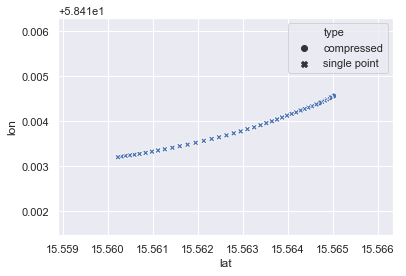

In [83]:
from dateutil.parser import parse
from math import radians, cos, sin, asin, sqrt, isnan
from pandas.core.series import Series
from typing import List
from pandas import DataFrame
from datetime import datetime, timedelta

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers
    return c * r
 
def stop_compress(data: DataFrame, delta: float) -> DataFrame:
    """ Downsamples the data such that each consecutive data point have a least 
    delta distance between each other. Loses station information.
    """

    def mean_timestamp(timestamps):    
        return pd.to_datetime(timestamps.values.astype(np.int64).mean())
 
    def compress(data: DataFrame) -> DataFrame:
        if data.shape[0] == 1:
            return data
        
        data.speed = np.max(data.speed, 0) # data contains -1 sentinel values for missing speed
        contains_entered_event = lambda df : data.event.transform(lambda e : e == 'EnteredEvent').any()
        
        special_treatment_fields = ['timestamp', 'event', 'seg', 'station', 'line', 'type', 'traj']
        compressed_data = data.drop(special_treatment_fields, axis=1).apply(np.mean, axis=0)
        
        # Since python is a shit language it will wrongly cast stuff 
        # unless explicitly provided a pd.Timestamp first
        compressed_data['timestamp'] = pd.Timestamp(2017, 1, 1, 12)
        compressed_data.timestamp = mean_timestamp(data.timestamp)
        compressed_data['event'] = 'EnteredEvent' if contains_entered_event(data) else 'ObservedPositionEvent'
        compressed_data['station'] = data[data.event == 'EnteredEvent'].station if contains_entered_event(data) else 'NaN'
        compressed_data['seg'] = data.seg.min() # In the case of overlapping segments we let the data belong to the first
        compressed_data['line'] = data.iloc[0].line
        compressed_data['traj'] = data.iloc[0].traj
        compressed_data['type'] = 'compressed'
        return compressed_data
   
    output = pd.DataFrame(columns=data.columns)
    data_buffer: List[Series] = [data.iloc[0]]
    for _, current in data.iterrows():
        distance = haversine(
            current.lat, 
            current.lon, 
            np.mean([x.lat for x in data_buffer]),
            np.mean([x.lon for x in data_buffer]))
   
        if distance > delta:
            output = output.append(compress(pd.DataFrame(data_buffer)), ignore_index=True)
            data_buffer.clear()
        
        data_buffer.append(current)

    output.append(compress(pd.DataFrame(data_buffer)), ignore_index=True)
    return output

#haversine(1,2,1,2)
X = seg_one
X['type'] = 'single point'
X['timestamp'] = pd.to_datetime(X.timestamp)
compressed_data = stop_compress(X, 3e-3)
sns.scatterplot(data=compressed_data, x='lat', y='lon', style='type')
compressed_data.head()
sorted_data = compressed_data.sort_values('timestamp')
sorted_data

In [42]:
print(seg_one.timestamp.head())
pd.to_datetime(seg_one.timestamp.head().values.astype(np.int64).mean())

33782   2018-02-16 11:23:20
33783   2018-02-16 11:23:21
33784   2018-02-16 11:23:22
33785   2018-02-16 11:23:23
33786   2018-02-16 11:23:24
Name: timestamp, dtype: datetime64[ns]


Timestamp('2018-02-16 11:23:22')

In [29]:
import datetime
your_timestamp = 1331856000000
date = datetime.datetime.fromtimestamp(your_timestamp / 1e3)
pd.DataFrame([date])

,0
0,2012-03-16 01:00:00
